# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 10000

In [10]:
start_row = int(800000-(dev_data_size/2))-1
finish_row = int(800000+(dev_data_size/2))-1
df_sm = df[start_row:finish_row]
df_sm.count()

sentiment    10000
ID           10000
Time         10000
none         10000
username     10000
Text         10000
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['im sitting alone at TTE myself without my two michigan sisters for the first time in a decade.  ',
       "@Julie90210 It took me three attempts but I got it in the end. I'm sorry for your loss  Did you try the DRU thing and iTunes restore?",
       'awake for summer school. ',
       "@AJBombers Just noticed it is an afternoon game, won't be able to make that game sorry, thanks for the offer but I will have to decline.. ",
       "Sorry for the long listening, but I'm too lazy for twitter  and I had to work hard in the last week",
       'Bleurgh...feeling rough ',
       'Hey @pcwoessner have to leave   back to work.   (Summer PD 09 live &gt; http://ustre.am/3mgf)',
       '@margxwanders awwwwwwwww! busy much?? miss you gaux! ',
       'Just got to work ', "@claireliz81 ....he caught Sanchez's disease "],
      dtype=object)

In [13]:
sentiments[4995:5005]

array([0, 0, 0, 0, 0, 4, 4, 4, 4, 4], dtype=int64)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [14]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    
    # The numbers in the data became a bit of a problem during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    # s = re.sub(r'\d+', '', s)
    
    
    
    
    
    return str(s)

## Create new column in dataframe

In [15]:
df_sm["text_clean"] = ''

# Iterate and clean

In [16]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 795000
processed: 796000
processed: 797000
processed: 798000
processed: 799000
processed: 800000
processed: 801000
processed: 802000
processed: 803000
processed: 804000


### Check results

In [17]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
794999,0,2327192646,Thu Jun 25 08:02:13 PDT 2009,NO_QUERY,quiz_master,"Was having dinner with parents downstairs in Dining Room, they started watching 'Baba Ramdev Yoga' thingy, so I'm back to my room .","Was having dinner with parents downstairs in Dining Room, they started watching 'Baba Ramdev Yoga' thingy, so I'm back to my room ."
795000,0,2327193206,Thu Jun 25 08:02:16 PDT 2009,NO_QUERY,djcampos,Blah 5am still up daang I got deep problems,Blah 5am still up daang I got deep problems
795001,0,2327193455,Thu Jun 25 08:02:17 PDT 2009,NO_QUERY,RKF,@jenspeedy I would suggest avoiding 360 Living. Not goodness Try contacting Scott at MKCC mkccrenovations@rogers.com 905-303-9009,@jenspeedy I would suggest avoiding 360 Living. Not goodness Try contacting Scott at MKCC mkccrenovations@rogers.com 905-303-9009
795002,0,2327193641,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,AnaHertz,@alexbroun I didn't convince myself I was fat and ugly someone else did a pretty good job of that. Its a long story sorry,@alexbroun I didn't convince myself I was fat and ugly someone else did a pretty good job of that. Its a long story sorry
795003,0,2327193806,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,yenafer,"@spotzle @jstarrh check on sunscreen, snacks, towels, suits, kids drinks, bags and tape for boys cast, camera. Need toys, chairs ugh :-/","@spotzle @jstarrh check on sunscreen, snacks, towels, suits, kids drinks, bags and tape for boys cast, camera. Need toys, chairs ugh :-/"


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [18]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [19]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [20]:
normalize_corpus = np.vectorize(normalize_document)

In [21]:
df_sm["text_normalized"] = ''

In [22]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 795000
processed: 796000
processed: 797000
processed: 798000
processed: 799000
processed: 800000
processed: 801000
processed: 802000
processed: 803000
processed: 804000


### check results

In [23]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
794999,0,2327192646,Thu Jun 25 08:02:13 PDT 2009,NO_QUERY,quiz_master,"Was having dinner with parents downstairs in Dining Room, they started watching 'Baba Ramdev Yoga' thingy, so I'm back to my room .","Was having dinner with parents downstairs in Dining Room, they started watching 'Baba Ramdev Yoga' thingy, so I'm back to my room .","dinner parents downstairs dining room started watching baba ramdev yoga ' thingy , ' back room ."
795000,0,2327193206,Thu Jun 25 08:02:16 PDT 2009,NO_QUERY,djcampos,Blah 5am still up daang I got deep problems,Blah 5am still up daang I got deep problems,blah 5am still daang got deep problems
795001,0,2327193455,Thu Jun 25 08:02:17 PDT 2009,NO_QUERY,RKF,@jenspeedy I would suggest avoiding 360 Living. Not goodness Try contacting Scott at MKCC mkccrenovations@rogers.com 905-303-9009,@jenspeedy I would suggest avoiding 360 Living. Not goodness Try contacting Scott at MKCC mkccrenovations@rogers.com 905-303-9009,jenspeedy would suggest avoiding 360 living goodness try contacting scott mkcc mkccrenovations @ rogers . com 905 - 303 - 9009
795002,0,2327193641,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,AnaHertz,@alexbroun I didn't convince myself I was fat and ugly someone else did a pretty good job of that. Its a long story sorry,@alexbroun I didn't convince myself I was fat and ugly someone else did a pretty good job of that. Its a long story sorry,alexbroun didnt convince fat ugly someone else pretty good job . long story sorry
795003,0,2327193806,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,yenafer,"@spotzle @jstarrh check on sunscreen, snacks, towels, suits, kids drinks, bags and tape for boys cast, camera. Need toys, chairs ugh :-/","@spotzle @jstarrh check on sunscreen, snacks, towels, suits, kids drinks, bags and tape for boys cast, camera. Need toys, chairs ugh :-/","spotzle jstarrh check sunscreen , snacks , towels , suits , kids drinks , bags tape boys cast , camera . need toys , chairs ugh :-/"
...,...,...,...,...,...,...,...,...
804994,4,1468599653,Tue Apr 07 02:39:03 PDT 2009,NO_QUERY,danalynbyers,"@lbran, thanks for sending us the package - got it this morning!","@lbran, thanks for sending us the package - got it this morning!",lbran thanks sending us package - got morning !
804995,4,1468599688,Tue Apr 07 02:39:04 PDT 2009,NO_QUERY,joscelinyeo,@ickleoriental hahahha.. U obviously don't hv one!! But maybe u can give me advice? Fdw.. Foreign domestic worker,@ickleoriental hahahha.. U obviously don't hv one!! But maybe u can give me advice? Fdw.. Foreign domestic worker,ickleoriental hahahha . u obviously ' hv one !! maybe u give advice ? fdw .. foreign domestic worker
804996,4,1468599702,Tue Apr 07 02:39:04 PDT 2009,NO_QUERY,serengetisunset,"@juliekoh It's an internet term, but it's spilled over into common use, in real life","@juliekoh It's an internet term, but it's spilled over into common use, in real life","juliekoh internet term , ' spilled common use , real life"
804997,4,1468599765,Tue Apr 07 02:39:06 PDT 2009,NO_QUERY,broombeck,new day.... NEW TRACK!!!!,new day.... NEW TRACK!!!!,new day .. new track !!!!


In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [25]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

795000
796000
797000
798000
799000
800000
801000
802000
803000
804000


In [26]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
794999,0,2327192646,Thu Jun 25 08:02:13 PDT 2009,NO_QUERY,quiz_master,"Was having dinner with parents downstairs in Dining Room, they started watching 'Baba Ramdev Yoga' thingy, so I'm back to my room .","Was having dinner with parents downstairs in Dining Room, they started watching 'Baba Ramdev Yoga' thingy, so I'm back to my room .","dinner parents downstairs dining room started watching baba ramdev yoga ' thingy , ' back room .","dinner parent downstairs dining room start watch baba ramdev yoga ' thingy , ' back room .",dinner parent dining room baba ramdev yoga thingy back room,,start watch,dinner parent dining room baba ramdev yoga thingy back room start watch,17.00
795000,0,2327193206,Thu Jun 25 08:02:16 PDT 2009,NO_QUERY,djcampos,Blah 5am still up daang I got deep problems,Blah 5am still up daang I got deep problems,blah 5am still daang got deep problems,blah 5 a.m. still daang get deep problem,blah a.m. daang problem,deep,get,blah a.m. daang problem deep get,8.00
795001,0,2327193455,Thu Jun 25 08:02:17 PDT 2009,NO_QUERY,RKF,@jenspeedy I would suggest avoiding 360 Living. Not goodness Try contacting Scott at MKCC mkccrenovations@rogers.com 905-303-9009,@jenspeedy I would suggest avoiding 360 Living. Not goodness Try contacting Scott at MKCC mkccrenovations@rogers.com 905-303-9009,jenspeedy would suggest avoiding 360 living goodness try contacting scott mkcc mkccrenovations @ rogers . com 905 - 303 - 9009,jenspeedy would suggest avoid 360 live goodness try contact scott mkcc mkccrenovation @ roger . com 905 - 303 - 9009,jenspeedy goodness try scott mkcc mkccrenovation roger com,,would suggest avoid live contact,jenspeedy goodness try scott mkcc mkccrenovation roger com would suggest avoid live contact,21.00
795002,0,2327193641,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,AnaHertz,@alexbroun I didn't convince myself I was fat and ugly someone else did a pretty good job of that. Its a long story sorry,@alexbroun I didn't convince myself I was fat and ugly someone else did a pretty good job of that. Its a long story sorry,alexbroun didnt convince fat ugly someone else pretty good job . long story sorry,alexbroun do not convince fat ugly someone else pretty good job . long story sorry,alexbroun fat job story,ugly good long sorry,convince,alexbroun fat job story ugly good long sorry convince,15.00
795003,0,2327193806,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,yenafer,"@spotzle @jstarrh check on sunscreen, snacks, towels, suits, kids drinks, bags and tape for boys cast, camera. Need toys, chairs ugh :-/","@spotzle @jstarrh check on sunscreen, snacks, towels, suits, kids drinks, bags and tape for boys cast, camera. Need toys, chairs ugh :-/","spotzle jstarrh check sunscreen , snacks , towels , suits , kids drinks , bags tape boys cast , camera . need toys , chairs ugh :-/","spotzle jstarrh check sunscreen , snack , towel , suit , kid drink , bag tape boy cast , camera . need toy , chair ugh :-/",spotzle jstarrh sunscreen snack towel suit kid drink bag tape boy camera toy chair :-/,,check cast need ugh,spotzle jstarrh sunscreen snack towel suit kid drink bag tape boy camera toy chair :-/ check cast need ugh,27.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804994,4,1468599653,Tue Apr 07 02:39:03 PDT 2009,NO_QUERY,danalynbyers,"@lbran, thanks for sending us the package - got it this morning!","@lbran, thanks for sending us the package - got it this morning!",lbran thanks sending us package - got morning !,lbran thank send us package - get morning !,lbran thank us package morning,,send get,lbran thank us package morning send get,9.00
804995,4,1468599688,Tue Apr 07 02:39:04 PDT 2009,NO_QUERY,joscelinyeo,@ickleoriental hahahha.. U obviously don't hv one!! But maybe u can give me advice? Fdw.. Foreign domestic worker,@ickleoriental hahahha.. U obviously don't hv one!! But maybe u can give me advice

In [27]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# Note this isn't necessary (the dataset is shuffled again before used), 
# but is good practice.
# df = df.sample(frac=1)

sentiment          10000
ID                 10000
Time               10000
none               10000
username           10000
Text               10000
text_clean         10000
text_normalized    10000
text_lemma         10000
text_nouns         10000
text_adjectives    10000
text_verbs         10000
text_nav           10000
no_tokens          10000
dtype: int64

In [28]:
# save cleaned data

df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

### Punctuation

I notice that the cleaning I have done so far has not removed punctuation. As I am scrambling to make a Milestone, I will neglect this important step until I feel I have a basic grip on the stuff I need to do to achieve that Milestone. But consider this oversight noted.

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [29]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [30]:
df_sm['sentiment'].value_counts()

4    5000
0    5000
Name: sentiment, dtype: int64

Excellent! Perfectly balanced.

### Show data types in each column

In [31]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [32]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,10000.00,2.00,2.00,0.00,0.00,2.00,4.00,4.00
ID,10000.00,1898211632.67,430002312.27,1467822272.00,1468239328.75,1897896219.50,2328188791.00,2329205794.00
no_tokens,10000.00,9.62,5.56,1.00,5.00,9.00,13.00,53.00


### Exploring word frequencies

In [33]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
800334,@fatbellybella the media is a trip [period] we have to guard our minds...along with our hearts. Don't fret ms.badu UR THE BEST!! its true,fatbellybella media trip period ] guard minds ... along hearts . ' fret ms . badu ur best !! true,fatbellybella medium trip period ] guard mind ... along heart . ' fret ms . badu ur best ! ! true,medium trip period guard mind heart fret ms . badu ur fatbellybella true
801842,"@SlideShare Dan Flickr for photos, Youtube for videos, Megaupload for large files. Own sites for articles. That's it.","slideshare dan flickr photos youtube videos , megaupload large files . sites articles . ' .","slideshare dan flickr photos youtube video , megaupload large file . site article . ' .",slideshare dan flickr photos youtube video file site article large megaupload
799093,"@barnoah Ah yes, there are quite a few Texans who come up and compete in the Rodeo at Stampede.. I don't have authentic boots",barnoah ah yes quite texans come compete rodeo stampede .. ' authentic boots,barnoah ah yes quite texans come compete rodeo stampede .. ' authentic boot,barnoah texans rodeo stampede boot compete authentic come
797521,Bob (the dog) in neighbours dies bad times,bob dog neighbours dies bad times,bob dog neighbours die bad time,bob dog neighbours time bad die
798854,Farah Fawcett is dead. Goodbye Charlie's Angel,farah fawcett dead goodbye charlies angel,farah fawcett dead goodbye charlie angel,farah fawcett goodbye charlie angel dead
802044,@routhietootie Camilla! I love your eyes! You have the cutest face! and the most gorgeous figure. Really good actor.,routhietootie camilla love eyes ! cutest face ! gorgeous figure . really good actor .,routhietootie camilla love eye ! cut face ! gorgeous figure . really good actor .,routhietootie camilla eye face figure actor cut gorgeous good love
800581,100 followers - that is exciting,100 followers exciting,100 follower exciting,follower exciting
801247,Is on butcher's hill for the evening. Going back to the west side in the early morn! Hope some followers find me in the meantime!,butchers hill evening going back west side early morn ! hope followers find meantime !,butchers hill evening go back west side early morn ! hope follower find meantime !,butchers hill evening side morn hope follower meantime west early go find
802245,@dalerankine You mean also in NZ and I should just stay at home in the rain?,dalerankine mean also nz stay home rain,dalerankine mean also nz stay home rain,dalerankine mean home rain stay
800610,noches twitterricolsss,noches twitterricolsss,noche twitterricolsss,twitterricolsss noche


In [34]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [35]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [36]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [37]:
print(tokens[:200])

['dinner', 'parent', 'dining', 'room', 'baba', 'ramdev', 'yoga', 'thingy', 'back', 'room', 'start', 'watch', 'blah', 'a.m.', 'daang', 'problem', 'deep', 'get', 'jenspeedy', 'goodness', 'try', 'scott', 'mkcc', 'mkccrenovation', 'roger', 'com', 'would', 'suggest', 'avoid', 'live', 'contact', 'alexbroun', 'fat', 'job', 'story', 'ugly', 'good', 'long', 'sorry', 'convince', 'spotzle', 'jstarrh', 'sunscreen', 'snack', 'towel', 'suit', 'kid', 'drink', 'bag', 'tape', 'boy', 'camera', 'toy', 'chair', ':-/', 'check', 'cast', 'need', 'ugh', 'tte', 'michigan', 'sister', 'time', 'decade', 'first', 'be', 'sit', 'julie90210', 'attempt', 'end', 'loss', 'dru', 'thing', 'itune', 'sorry', 'take', 'get', 'try', 'restore', 'awake', 'summer', 'school', 'ajbomber', 'afternoon', 'game', 'game', 'thank', 'decline', 'able', 'sorry', 'notice', 'make', 'offer', 'twitter', 'work', 'week', 'long', 'lazy', 'last', 'listen', 'be', 'bleurgh', 'rough', 'feel', 'pcwoessner', 'work', 'summer', 'pd', 'leave', 'live', 'mar

### Counting Frequencies with a Counter

In [38]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('go', 1086),
 ('get', 791),
 ('be', 715),
 ('good', 665),
 ('day', 647),
 ('work', 604),
 ('today', 487),
 ('farrah', 471),
 ('time', 431),
 ('quot', 426),
 ('love', 411),
 ('sad', 390),
 ('know', 369),
 ('see', 363),
 ('think', 361),
 ('want', 351),
 ('miss', 348),
 ('make', 346),
 ('fawcett', 345),
 ('thank', 339)]

In [39]:
print([t[0] for t in counter.most_common(200)]) 

['go', 'get', 'be', 'good', 'day', 'work', 'today', 'farrah', 'time', 'quot', 'love', 'sad', 'know', 'see', 'think', 'want', 'miss', 'make', 'fawcett', 'thank', 'feel', 'morning', 'new', 'night', 'come', 'look', 'can', 'lol', 'need', 'would', 'hope', 'take', 'say', 's', 'watch', 'last', 'twitter', 'sleep', 'u', 'great', 'try', 'bad', 'wish', 'die', 'could', 'week', 'thing', 'tomorrow', 'wait', 'find', 'rip', 'happy', 'start', 'leave', 'nice', 'friend', 'fun', 'way', 'bed', 'people', 'show', 'much', 'tonight', 'hour', 'guy', 'use', 'life', 'pass', 'do', 'may', 'hate', 'hear', 'tweet', 'hot', 'give', 'old', 'have', 'man', 'home', 'let', 'rest', 'call', 'big', 'school', 'year', 'keep', 'tell', 'sorry', 'read', 'eat', 'little', 'lose', 'follow', 'help', 'break', 'suck', 'long', '@', 'talk', 'haha', 'sick', 'head', 'next', 'well', 'angel', 'awesome', 'play', 'cool', 'first', '#', 'yay', 'peace', 'sound', 'glad', 'guess', 'world', 'put', 'phone', 'mean', 'tired', 'house', 'check', 'buy', 'go

### Remove stopwords from list of tokens

In [40]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

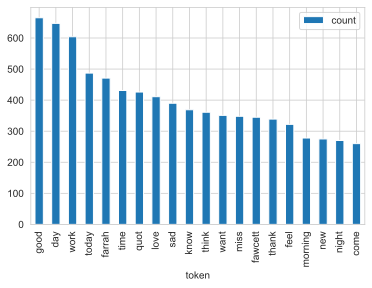

In [41]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

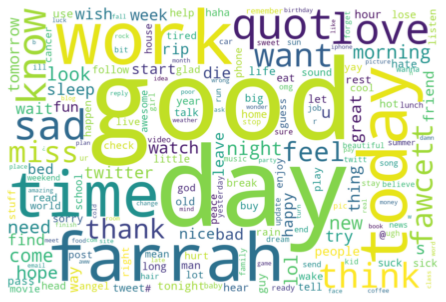

In [44]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

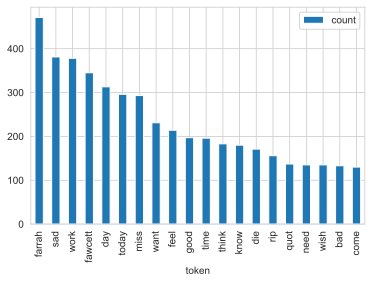

In [45]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

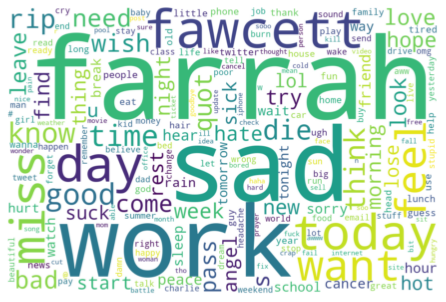

In [46]:
wordcloud(neg_counter)

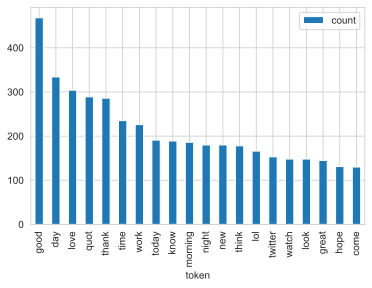

In [47]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

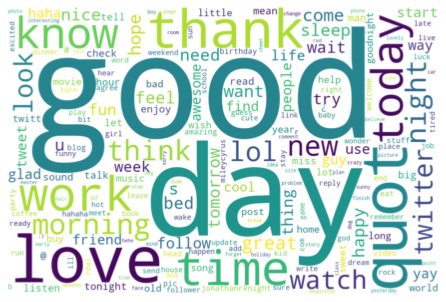

In [48]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [49]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

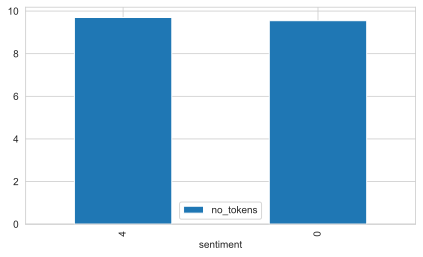

In [50]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [51]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

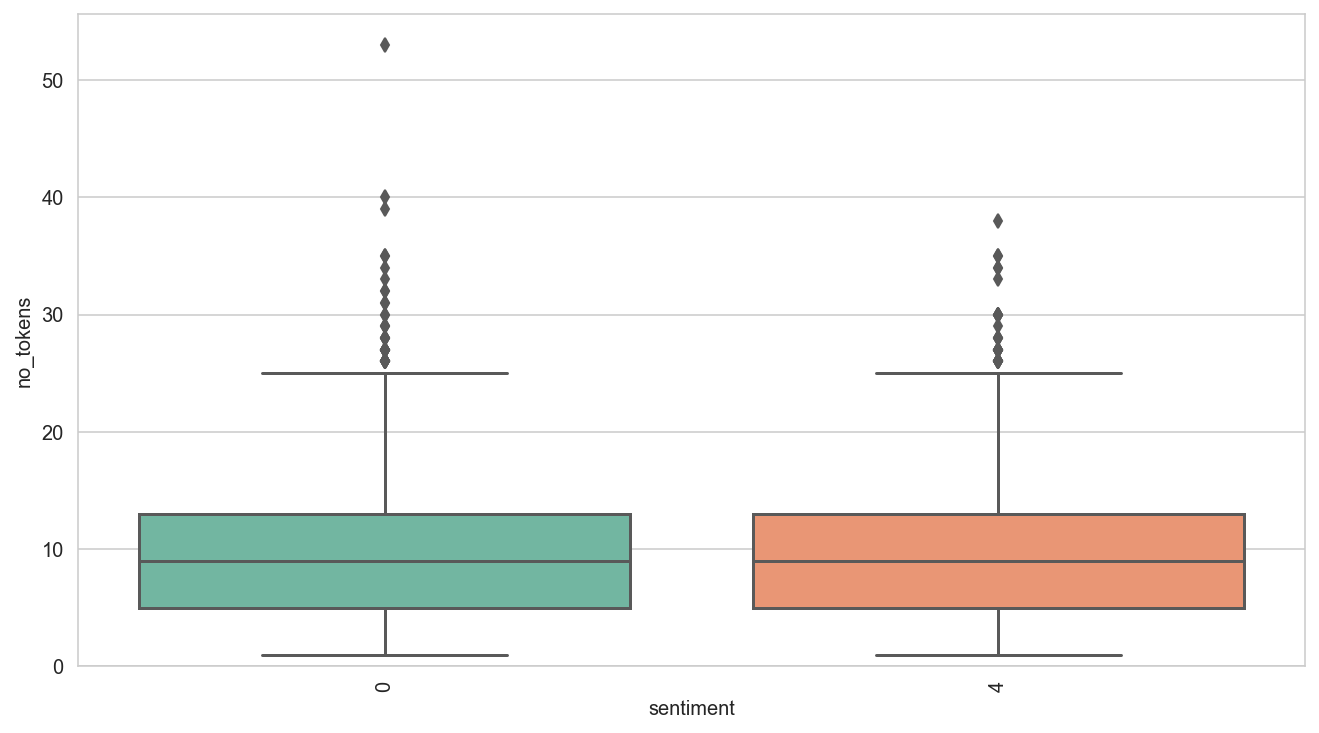

In [52]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [53]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [54]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,00am,0k,0sn,1000th,100th,101th,1028am,1041pm,10hrs,10mbs,10min,10th,10v,11ish,11mo,...,½i,½ll,½m,½n,½nefï,½o,½re,½rmï,½s,½se,½stand,½tï,½y,½ï,ã¼ã
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [57]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0

In [58]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,able,afternoon,ajbomber,alexbroun,attempt,avoid,awake,bag,be,blah,boy,camera,cast,chair,check,...,take,tape,thank,thing,time,towel,toy,try,tte,twitter,ugh,ugly,week,work,would
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,...,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [59]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

,00am big,0k right,0sn argh,1000th follower,1000th tweet,100th annoying,101th quot,1028am topic,1041pm black,10hrs go,10mbs connection,10min irritable,10th 29th,10th be,10v want,...,½n monitor,½n ng,½nefï ½n,½o ½c,½re fucking,½re second,½rmï quot,½s poker,½s xd,½se auf,½stand shoulder,½tï ½ainï,½y bay,½ï ½ï,ã¼ã thong
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [60]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,able sorry,afternoon game,ajbomber afternoon,alexbroun fat,attempt end,avoid live,awake summer,bag tape,be sit,blah daang,boy camera,camera toy,cast need,chair check,check cast,...,take get,tape boy,thank decline,thing itune,time decade,towel suit,toy chair,try restore,try scott,tte michigan,twitter work,ugly good,week long,work week,would suggest
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,...,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,00am,0k,0sn,1000th,100th,101th,1028am,1041pm,10hrs,10mbs,10min,10th,10v,11ish,11mo,...,½i,½ll,½m,½n,½nefï,½o,½re,½rmï,½s,½se,½stand,½tï,½y,½ï,ã¼ã
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9996,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9997,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [62]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,able,afternoon,ajbomber,alexbroun,attempt,avoid,awake,bag,be,blah,boy,camera,cast,chair,check,...,take,tape,thank,thing,time,towel,toy,try,tte,twitter,ugh,ugly,week,work,would
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.46,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.28
2,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.24,0.00,0.00,0.24,0.24,0.24,0.24,0.24,...,0.00,0.24,0.00,0.00,0.00,0.24,0.24,0.00,0.00,0.00,0.24,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.30,0.00,0.00,0.30,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.28,0.28,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.37,0.37,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=200)
selected_features = \
selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([  211,   231,   310,   319,   509,   594,   736,   946,   968,   972,
         978,  1051,  1159,  1181,  1190,  1232,  1280,  1400,  1495,  1585,
        1722,  1911,  1912,  1929,  2025,  2039,  2045,  2048,  2084,  2290,
        2311,  2403,  2659,  2681,  2746,  2749,  2815,  2865,  2920,  2923,
        2998,  3059,  3100,  3125,  3279,  3393,  3409,  3506,  3745,  3932,
        4135,  4149,  4304,  4387,  4416,  4434,  4442,  4454,  4479,  4480,
        4511,  4710,  4711,  4938,  4953,  5196,  5233,  5273,  5274,  5281,
        5391,  5498,  5540,  5544,  5557,  5571,  5622,  5659,  5662,  5706,
        5724,  5735,  5755,  5756,  5870,  6024,  6032,  6129,  6145,  6199,
        6219,  6643,  6884,  6893,  7000,  7239,  7493,  7498,  7582,  7777,
        7855,  7869,  7917,  7920,  7942,  7985,  7998,  8014,  8328,  8413,
        8427,  8573,  8583,  8653,  8719,  8840,  8854,  8904,  8947,  9059,
        9204,  9275,  9283,  9304,  9324,  9331,  9735,  9818,  9822,  9913,

In [64]:
vectorizer = TfidfVectorizer(min_df=15, vocabulary=selected_features)

bow_selected = vectorizer.fit_transform(df_sm['text_nav'])

np.set_printoptions(threshold=100)

print(selector.scores_)

[1. 1. 1. ... 1. 3. 1.]


In [65]:
np.set_printoptions(threshold=np.inf)
print(selector.scores_)
np.set_printoptions(threshold=200)

[1.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 1.00e+00 3.33e-01 0.00e+00 1.00e+00 1.00e+00
 1.00e+00 2.00e+00 1.00e+00 1.00e+00 2.00e+00 1.00e+00 5.29e-01 1.00e+00
 3.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 3.33e-01 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 3.33e-01 3.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 6.67e-02 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 3.33e-01 5.00e+00 1.43e-01 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 2.00e-01 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 0.00e+00 1.00e+00 0.00e+00 2.00e+00 1.00e+00 1.00e

 3.00e+00 1.00e+00]


In [66]:


# Create and fit selector
selector_micro = SelectKBest(chi2, k=30)
cv_micro_matrix_new = selector_micro.fit_transform(cv_micro_matrix, df_micro['sentiment'])
# Get columns to keep
cols_micro = selector_micro.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
#features_df_new = features_df[cols]
cols_micro

##vocab = cv_micro.get_feature_names()
#vocab[np.array(2, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
#       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
#       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71)]
#cv_micro_matrix_new = SelectKBest(chi2, k=50).fit_transform(cv_micro_matrix, df_micro['sentiment'])

#mask = cv_micro_matrix_new.get_support()
#mask
#new_features = df_micro.columns[mask]

#vocab_selected = cv_micro_matrix_new.get_feature_names()

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], dtype=int64)

In [67]:
pd.DataFrame(np.round(cv_micro_matrix_new, 2)) #, columns=vocab_micro[cols])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0


## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [68]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [69]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(model, 50)
fit = rfe.fit(bow_selected, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 50
Selected Features: [False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True  True
  True  True  Tr

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [70]:
from sklearn.ensemble import ExtraTreesClassifier

In [71]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
np.set_printoptions(threshold=200)

[0.00e+00 0.00e+00 2.01e-05 1.95e-07 3.25e-06 2.63e-07 0.00e+00 0.00e+00
 0.00e+00 1.41e-06 3.34e-06 1.11e-04 7.29e-07 0.00e+00 0.00e+00 0.00e+00
 7.26e-06 0.00e+00 0.00e+00 2.04e-05 0.00e+00 1.33e-06 0.00e+00 1.93e-07
 0.00e+00 9.46e-05 3.29e-06 1.33e-06 4.78e-06 0.00e+00 0.00e+00 1.03e-06
 5.61e-05 1.76e-07 5.45e-07 1.92e-07 2.38e-05 1.70e-04 1.87e-04 2.66e-05
 0.00e+00 6.49e-05 2.23e-06 3.02e-05 5.48e-07 0.00e+00 5.97e-05 1.83e-05
 0.00e+00 0.00e+00 0.00e+00 2.90e-05 0.00e+00 5.05e-06 0.00e+00 3.20e-05
 3.07e-05 0.00e+00 9.52e-07 8.62e-05 0.00e+00 0.00e+00 3.02e-05 0.00e+00
 0.00e+00 3.17e-05 0.00e+00 5.05e-06 2.50e-05 7.72e-05 0.00e+00 2.32e-06
 1.72e-06 4.67e-04 8.80e-05 3.64e-05 3.68e-06 3.79e-06 0.00e+00 0.00e+00
 2.88e-06 6.44e-07 2.15e-05 1.34e-05 0.00e+00 0.00e+00 1.68e-05 0.00e+00
 1.15e-05 2.10e-06 2.54e-05 0.00e+00 0.00e+00 0.00e+00 2.09e-05 2.22e-05
 2.34e-05 3.24e-06 4.42e-07 2.68e-04 0.00e+00 3.07e-05 0.00e+00 2.57e-06
 4.04e-07 1.55e-06 0.00e+00 1.23e-05 9.52e-07 3.60e

 2.87e-07 0.00e+00]


## Feature Selection on TF-IDF encoded features

### Wrapper Method - SelectKBest

In [72]:
selector_tfidf = SelectKBest(chi2, k=200)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([  211,   231,   310,   319,   509,   594,   736,   946,   968,   972,
         978,  1051,  1159,  1181,  1190,  1232,  1280,  1400,  1495,  1585,
        1622,  1722,  1911,  1912,  1929,  2025,  2039,  2045,  2048,  2084,
        2290,  2311,  2403,  2646,  2664,  2681,  2746,  2749,  2815,  2865,
        2920,  2923,  2998,  3059,  3100,  3125,  3279,  3393,  3409,  3506,
        3650,  3745,  3932,  4135,  4149,  4304,  4416,  4434,  4442,  4454,
        4479,  4480,  4511,  4710,  4711,  5196,  5203,  5233,  5273,  5274,
        5281,  5391,  5498,  5540,  5544,  5571,  5622,  5659,  5662,  5706,
        5724,  5735,  5743,  5755,  5756,  5870,  6024,  6032,  6129,  6145,
        6199,  6219,  6643,  6884,  6893,  7000,  7239,  7493,  7582,  7777,
        7855,  7869,  7917,  7920,  7942,  7985,  7998,  8014,  8328,  8364,
        8413,  8573,  8583,  8653,  8719,  8840,  8854,  8904,  9059,  9275,
        9283,  9304,  9324,  9331,  9571,  9735,  9818,  9822,  9913,  9979,

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [73]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
np.set_printoptions(threshold=200)

[1.78e-05 1.92e-06 3.06e-05 1.94e-06 0.00e+00 9.37e-07 2.60e-08 9.60e-06
 7.41e-06 8.45e-08 1.93e-05 1.03e-04 8.48e-06 0.00e+00 0.00e+00 0.00e+00
 1.34e-05 4.42e-05 0.00e+00 1.13e-05 3.35e-06 0.00e+00 0.00e+00 9.02e-06
 2.17e-06 4.39e-05 9.70e-07 1.15e-06 1.70e-06 2.01e-06 2.39e-07 7.04e-06
 5.57e-05 2.48e-06 4.75e-07 2.92e-05 4.03e-05 6.44e-05 2.76e-04 4.62e-05
 5.48e-05 1.56e-05 2.93e-06 3.30e-05 1.01e-06 1.91e-05 3.68e-05 3.23e-05
 8.82e-06 6.06e-06 4.41e-05 1.32e-04 4.35e-08 7.31e-07 2.80e-06 3.26e-05
 1.16e-05 1.59e-05 1.19e-05 1.59e-04 2.55e-05 3.59e-07 2.57e-07 5.56e-05
 4.26e-06 3.35e-06 1.60e-06 2.10e-07 3.06e-05 8.05e-05 0.00e+00 2.76e-06
 2.26e-05 5.12e-04 6.81e-05 9.01e-05 3.94e-06 1.79e-06 0.00e+00 0.00e+00
 1.76e-05 3.92e-06 4.35e-05 1.35e-05 1.44e-06 2.17e-05 9.77e-06 9.57e-08
 1.19e-05 4.49e-06 3.42e-05 1.46e-05 0.00e+00 0.00e+00 9.65e-06 6.16e-06
 4.73e-07 0.00e+00 4.85e-07 2.77e-04 1.23e-05 9.05e-06 5.04e-06 6.83e-06
 3.17e-06 0.00e+00 1.45e-05 4.02e-06 0.00e+00 8.54e

 2.45e-07 1.19e-05]


# Milestone 1 - Conclusion

### Data has been loaded, cleaned, and explored.

### Feature Engineering has been carried out using Bag of Words, Bag of N-Grams, and TF-IDF (Term Frequency - Inverse Document Frequency)

### Three Feature Selection methods, Select K Best, Recursive Feature Elimination, and Bagged Decision Trees, have been carried out on the engineered features.

### A sample of cleaned data has been saved to a file, for use in an "Advanced" part of this project using Tensorflow and ELMo in The Cloud.

Dec 14 2019

#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [74]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [75]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [76]:
for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
    print('TEXT:', texts)
    print('Actual Sentiment:', sentiment)
    print('Predicted Sentiment polarity:', afn.score(texts))
    print('-'*60)

TEXT: ['dinner parent dining room baba ramdev yoga thingy back room start watch'
 'blah a.m. daang problem deep get'
 'jenspeedy goodness try scott mkcc mkccrenovation roger com would suggest avoid live contact'
 ... 'juliekoh internet term use life common real spill' 'new day track new'
 'competition cantonese bet win dodgy need see']
Actual Sentiment: 0


TypeError: cannot use a string pattern on a bytes-like object

In [ ]:
# Predict sentiment with Afinn

sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [ ]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [ ]:
df_sm.head()

## Save to database

In [ ]:
df.to_sql('df_sm', con)